In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.optim import Adam
from torch.autograd import Variable
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from pathlib import Path
import gdown
from tqdm.notebook import tqdm
import time

In [3]:
%%capture
from typing import Type

RESISC45_DIR = Path("..") / "NWPU-RESISC45"
if not RESISC45_DIR.exists():
    gdown.download(
        id="1nd0R9iljzkWd7Hhfyp2tH55KxAsKrzYj",
        output="./NWPU-RESISC45.rar",
    )
    !unrar x ./NWPU-RESISC45.rar
    !mv NWPU-RESISC45 ..

In [4]:
# Find mean and standard deviation of data
def get_mean_and_std():
    transformations = transforms.Compose([transforms.ToTensor()])
    dataset = ImageFolder(root=RESISC45_DIR, transform=transformations)
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

    mean = 0.0
    std = 0.0
    total_samples = 0

    for images, _ in loader:
        batch_size = images.size(0)
        images = images.view(batch_size, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_samples += batch_size

    mean /= total_samples
    std /= total_samples

    print(f"Mean: {mean}")
    print(f"Std: {std}")

In [18]:
mean = (0.3680, 0.3810, 0.3436)
std = (0.1454, 0.1356, 0.1320)

# Test/train split
train_ratio = 0.8
test_ratio = 0.2

# Learning settings
batch_size = 64
learning_rate = 0.0002

channel_sizes = (20, 40, 20, 10)
linear_size = 10 * 64 * 64

normalizer = nn.Identity

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # to use M1 mac gpu
else:
    device = torch.device("cpu")

In [19]:
# Loading and normalizing the data.

transformations = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean, std)]
)

dataset = ImageFolder(root=RESISC45_DIR, transform=transformations)
classes = dataset.class_to_idx

train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [20]:
# Define a convolution neural network
class Network(nn.Module):
    def __init__(
        self,
        linear_size,
        channel_sizes,
        activation=F.relu,
        norm: Type[nn.Module] = nn.BatchNorm2d,
    ):
        super().__init__()

        self.linear_size = linear_size
        self.activation = activation

        self.pool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(p=0.5)

        c1, c2, c3, c4 = channel_sizes

        # First convolution
        self.conv1 = nn.Conv2d(3, c1, kernel_size=3, padding=1)
        self.norm1 = norm(c1)

        self.conv2 = nn.Conv2d(c1, c2, kernel_size=3, padding=1)
        self.norm2 = norm(c2)

        # Second convolution
        self.conv3 = nn.Conv2d(c2, c3, kernel_size=3, padding=1)
        self.norm3 = norm(c3)

        self.conv4 = nn.Conv2d(c3, c4, kernel_size=3, padding=1)
        self.norm4 = norm(c4)

        # Linear
        self.linear = nn.Linear(linear_size, 45)

    def forward(self, x):
        batch_size = x.size(0)

        activation = self.activation
        maxpool = self.pool
        dropout = self.dropout

        # First convolution
        # https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout
        x = self.norm1(self.conv1(x))
        x = dropout(activation(x))

        x = self.norm2(self.conv2(x))
        x = dropout(activation(x))

        x = maxpool(x)

        # Second convolution
        # https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout
        x = self.norm3(self.conv3(x))
        x = dropout(activation(x))

        x = self.norm4(self.conv4(x))
        x = dropout(activation(x))

        x = maxpool(x)

        # Linear
        x = x.reshape(batch_size, self.linear_size)
        x = self.linear(x)

        return x


# Instantiate a neural network model
model = Network(linear_size, channel_sizes, norm=normalizer)

In [21]:
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

In [23]:
# Function to save the model
def save_model(this_model, new_path="./model.pth"):
    path = new_path
    torch.save(this_model.state_dict(), path)


# Function to test the model with the test dataset and print the accuracy for the test images
def compute_train_accuracy(this_model: torch.nn.Module):
    accuracy = 0.0
    total = 0

    # Turn on evaluation mode
    this_model.eval()
    with torch.no_grad():
        for images, labels in tqdm(train_loader, desc="Train Acc"):
            images = images.to(device)
            labels = labels.to(device)

            # run the model on the test set to predict labels
            outputs = this_model(images)

            # the label with the highest value will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            accuracy += (predicted == labels).sum().item()

            total += labels.size(0)

    # compute the accuracy percentage over all test images
    accuracy = (accuracy / total) * 100
    return accuracy


def compute_test_accuracy(this_model: torch.nn.Module):
    accuracy = 0.0
    total = 0

    # Turn on evaluation mode
    this_model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Test Acc"):
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # run the model on the test set to predict labels
            outputs = this_model(images)

            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            accuracy += (predicted == labels).sum().item()

            total += labels.size(0)

    # compute the accuracy over all test images
    accuracy = (accuracy / total) * 100
    return accuracy


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs, *, log_train_acc):
    # Define your execution device
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")  # to use M1 mac gpu
    else:
        device = torch.device("cpu")
    print(f"Running on `{device}`.")

    # keep track of accuracy
    best_accuracy = 0.0

    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    start_time = time.time()

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        model.train()

        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in tqdm(
            enumerate(train_loader, 0), total=len(train_loader), desc="Train"
        ):
            # get the inputs
            images = images.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # predict classes using images from the training set
            outputs = model(images)

            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)

            # backpropagate the loss
            loss.backward()

            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 100 images
            running_loss += loss.item()  # extract the loss value
            if i % 100 == 99:
                # print every 100 images
                print(
                    f"[Epoch {epoch + 1:2d}]: "
                    f"Average loss at {i + 1:3d} iterations: {running_loss / (i + 1):.3f}"
                )

        print(f"finishing epoch {epoch}. elapsed time: {time.time() - start_time}")

        end = len(train_loader)
        print(
            f"[Epoch {epoch + 1:2d}]: "
            f"Average loss at {end:3d} iterations: {running_loss / end:.3f}"
        )

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        if log_train_acc:
            train_accuracy = compute_train_accuracy(model)
            print(f"[Epoch {epoch + 1:2d}]: Train accuracy: {train_accuracy:.2f}%")

        test_accuracy = compute_test_accuracy(model)
        print(f"[Epoch {epoch + 1:2d}]: Test accuracy: {test_accuracy:.2f}%")

        # we want to save the model if the accuracy is the best
        if test_accuracy > best_accuracy:
            save_model(model)
            best_accuracy = test_accuracy

In [24]:
# Let's build our model
train(10, log_train_acc=True)
print("Finished Training")

# Test which classes performed well
compute_test_accuracy(model)

Running on `cuda`.


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  1]: Average loss at 100 iterations: 3.577
[Epoch  1]: Average loss at 200 iterations: 3.301
[Epoch  1]: Average loss at 300 iterations: 3.093
finishing epoch 0. elapsed time: 90.19177746772766
[Epoch  1]: Average loss at 394 iterations: 2.950


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  1]: Train accuracy: 15.00%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  1]: Test accuracy: 13.40%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  2]: Average loss at 100 iterations: 2.270
[Epoch  2]: Average loss at 200 iterations: 2.231
[Epoch  2]: Average loss at 300 iterations: 2.224
finishing epoch 1. elapsed time: 266.531320810318
[Epoch  2]: Average loss at 394 iterations: 2.202


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  2]: Train accuracy: 19.93%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  2]: Test accuracy: 15.87%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  3]: Average loss at 100 iterations: 1.872
[Epoch  3]: Average loss at 200 iterations: 1.852
[Epoch  3]: Average loss at 300 iterations: 1.862
finishing epoch 2. elapsed time: 444.0301229953766
[Epoch  3]: Average loss at 394 iterations: 1.867


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  3]: Train accuracy: 27.07%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  3]: Test accuracy: 19.37%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  4]: Average loss at 100 iterations: 1.511
[Epoch  4]: Average loss at 200 iterations: 1.522
[Epoch  4]: Average loss at 300 iterations: 1.508
finishing epoch 3. elapsed time: 621.2474644184113
[Epoch  4]: Average loss at 394 iterations: 1.516


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  4]: Train accuracy: 41.27%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  4]: Test accuracy: 23.65%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  5]: Average loss at 100 iterations: 1.100
[Epoch  5]: Average loss at 200 iterations: 1.117
[Epoch  5]: Average loss at 300 iterations: 1.130
finishing epoch 4. elapsed time: 797.7487070560455
[Epoch  5]: Average loss at 394 iterations: 1.146


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  5]: Train accuracy: 58.77%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  5]: Test accuracy: 26.94%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  6]: Average loss at 100 iterations: 0.757
[Epoch  6]: Average loss at 200 iterations: 0.786
[Epoch  6]: Average loss at 300 iterations: 0.792
finishing epoch 5. elapsed time: 974.4124836921692
[Epoch  6]: Average loss at 394 iterations: 0.810


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  6]: Train accuracy: 70.93%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  6]: Test accuracy: 29.08%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  7]: Average loss at 100 iterations: 0.499
[Epoch  7]: Average loss at 200 iterations: 0.511
[Epoch  7]: Average loss at 300 iterations: 0.540
finishing epoch 6. elapsed time: 1150.2586607933044
[Epoch  7]: Average loss at 394 iterations: 0.564


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  7]: Train accuracy: 81.85%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  7]: Test accuracy: 30.32%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  8]: Average loss at 100 iterations: 0.354
[Epoch  8]: Average loss at 200 iterations: 0.371
[Epoch  8]: Average loss at 300 iterations: 0.392
finishing epoch 7. elapsed time: 1325.6355662345886
[Epoch  8]: Average loss at 394 iterations: 0.407


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  8]: Train accuracy: 84.96%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  8]: Test accuracy: 29.17%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  9]: Average loss at 100 iterations: 0.264
[Epoch  9]: Average loss at 200 iterations: 0.267
[Epoch  9]: Average loss at 300 iterations: 0.288
finishing epoch 8. elapsed time: 1501.514375925064
[Epoch  9]: Average loss at 394 iterations: 0.307


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  9]: Train accuracy: 88.17%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  9]: Test accuracy: 29.43%


Train:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 10]: Average loss at 100 iterations: 0.207
[Epoch 10]: Average loss at 200 iterations: 0.223
[Epoch 10]: Average loss at 300 iterations: 0.245
finishing epoch 9. elapsed time: 1677.6404740810394
[Epoch 10]: Average loss at 394 iterations: 0.259


Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 10]: Train accuracy: 91.98%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 10]: Test accuracy: 31.56%
Finished Training


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

31.555555555555554

In [13]:
import matplotlib.pyplot as plt
import numpy as np


# Function to show the images
def show_image(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def test_batch():
    # get batch of images from the test DataLoader
    images, labels = next(iter(test_loader))

    # show all images as one image grid
    show_image(torchvision.utils.make_grid(images))

    # Show the real labels on the screen
    print(
        "Real labels: ",
        " ".join("%5s" % list(classes.keys())[labels[j]] for j in range(batch_size)),
    )

    # Let's see what if the model identifiers the  labels of those example
    outputs = model(images)

    print(outputs)

    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)

    # Let's show the predicted labels on the screen to compare with the real ones
    print(
        "Predicted: ",
        " ".join("%5s" % list(classes.keys())[predicted[j]] for j in range(batch_size)),
    )

In [14]:
# Let's load the model we just created and test the accuracy per label
print(device)
model = Network(linear_size, channel_sizes, norm=normalizer)
path = "model.pth"
model.load_state_dict(torch.load(path, map_location=torch.device(device)))

cuda


<All keys matched successfully>

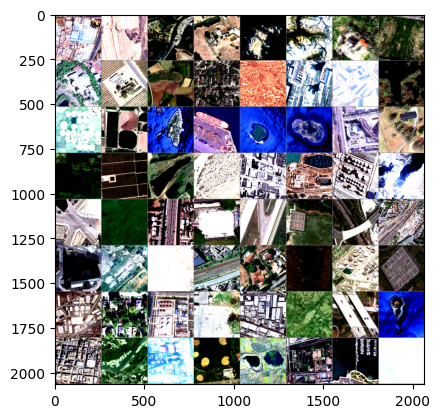

Real labels:  industrial_area terrace river sparse_residential island snowberg sparse_residential meadow church sparse_residential terrace dense_residential desert thermal_power_station terrace wetland circular_farmland circular_farmland island  ship island island thermal_power_station sparse_residential forest rectangular_farmland  lake chaparral industrial_area stadium storage_tank snowberg intersection meadow freeway basketball_court runway basketball_court overpass railway_station church airport desert railway medium_residential wetland storage_tank basketball_court industrial_area medium_residential storage_tank basketball_court industrial_area wetland overpass island commercial_area river thermal_power_station baseball_diamond  lake thermal_power_station harbor thermal_power_station
tensor([[ -6.2962,  -2.9417, -14.8717,  ...,  -8.5233,  -2.1626, -24.5879],
        [ -0.3535,  -0.6749,  -3.6049,  ...,   3.9326,  -1.5338, -10.1532],
        [-13.8093,  -4.0328,  -2.9527,  ...,  -2

In [15]:
test_batch()

In [ ]:
# CREATE TINY DATASET
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

image_size = (256, 256)

data_transforms = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        ),  # ImageNet normalization
    ]
)

downsize_dataset = ImageFolder(RESISC45_DIR, transform=data_transforms)

target_array = downsize_dataset.targets

train_indices, test = train_test_split(
    range(len(target_array)), train_size=675, random_state=69, stratify=target_array
)

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)

train_loader = DataLoader(
    downsize_dataset, batch_size=1, sampler=train_sampler, num_workers=4
)

In [26]:
# wrap adversarial construction code in a function
def make_adversarial_example(x: torch.Tensor, model: torch.nn.Module, steps: int):
    # require batch dimension
    assert x.ndim >= 2
    n_batch = x.shape[0]

    # x = x.detach().reshape(n_batch, 1, 16000)
    x = x.detach().reshape(
        x.shape
    )  # match the size of the input (for images it's n_batch x 3 x 256 x 256)
    delta = torch.zeros_like(x).requires_grad_(True)

    # obtain original predictions; we'll perform an `untargeted` attack in which we simply
    # seek incorrect predictions rather than a specific class
    with torch.no_grad():
        preds = model(x).argmax(dim=-1).long()

    # evaluation mode
    model.eval()

    for i in range(steps):
        delta.grad = None

        outputs = model(x + delta)
        loss = torch.nn.functional.cross_entropy(outputs, preds)

        loss.backward()
        grad = delta.grad.detach()

        with torch.no_grad():
            # ascend rather than descend the gradient (untargeted attack)
            delta += (grad / (grad.norm() + 1e-12)) * 0.005

    # restore train mode
    model.train()

    # return example plus our perturbation
    return x + delta.detach()


# choose how many attack steps we perform -- more steps means more robustness, but at the
# cost of a linear increase in training time
attack_steps = 5

# number of epochs to train
epochs = 10

# initialize the model
robust_model = Network(linear_size, channel_sizes, norm=normalizer)
robust_model.to(device)

# use an optimizer to handle parameter updates
optimizer = torch.optim.SGD(robust_model.parameters(), lr=0.001, momentum=0.9)

# train using categorical cross-entropy loss
criterion = torch.nn.CrossEntropyLoss()

# keep track of overall model accuracy; ultimately, we will keep the most accurate model
best_accuracy = 0.0
best_model = None

for epoch in range(epochs):
    # track loss
    training_loss = 0.0
    validation_loss = 0

    # track accuracy
    correct = 0
    total = 0

    pbar = tqdm(train_loader, total=len(train_loader))

    model.train()
    for batch_idx, batch_data in enumerate(pbar):
        pbar.set_description(
            f"Epoch {epoch + 1}, batch {batch_idx + 1}/{len(train_loader)}"
        )

        inputs, labels = batch_data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # adversarially perturb inputs
        inputs = make_adversarial_example(inputs, robust_model, attack_steps)

        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = robust_model(inputs)

        # calculate loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # sum training loss
        training_loss += loss.item()

    train_accuracy = compute_train_accuracy(robust_model)
    print(f"[Epoch {epoch + 1:2d}]: Train accuracy: {train_accuracy:.2f}%")

    test_accuracy = compute_test_accuracy(robust_model)
    print(f"[Epoch {epoch + 1:2d}]: Test accuracy: {test_accuracy:.2f}%")

    # if best model thus far, save it
    if test_accuracy > best_accuracy:
        print(f"New best accuracy: {test_accuracy}; saving model")
        save_model(robust_model, "./adver_model.pth")
        best_accuracy = test_accuracy

  0%|          | 0/394 [00:00<?, ?it/s]

Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  1]: Train accuracy: 14.25%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  1]: Test accuracy: 12.90%
New best accuracy: 12.904761904761905; saving model


  0%|          | 0/394 [00:00<?, ?it/s]

Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  2]: Train accuracy: 24.83%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  2]: Test accuracy: 19.06%
New best accuracy: 19.063492063492063; saving model


  0%|          | 0/394 [00:00<?, ?it/s]

Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  3]: Train accuracy: 26.98%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  3]: Test accuracy: 18.38%


  0%|          | 0/394 [00:00<?, ?it/s]

Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  4]: Train accuracy: 38.08%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  4]: Test accuracy: 21.71%
New best accuracy: 21.714285714285715; saving model


  0%|          | 0/394 [00:00<?, ?it/s]

Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  5]: Train accuracy: 54.36%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  5]: Test accuracy: 25.86%
New best accuracy: 25.857142857142858; saving model


  0%|          | 0/394 [00:00<?, ?it/s]

Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  6]: Train accuracy: 56.81%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  6]: Test accuracy: 24.78%


  0%|          | 0/394 [00:00<?, ?it/s]

Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  7]: Train accuracy: 65.35%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  7]: Test accuracy: 26.32%
New best accuracy: 26.317460317460316; saving model


  0%|          | 0/394 [00:00<?, ?it/s]

Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  8]: Train accuracy: 78.16%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  8]: Test accuracy: 29.40%
New best accuracy: 29.3968253968254; saving model


  0%|          | 0/394 [00:00<?, ?it/s]

Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch  9]: Train accuracy: 80.55%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch  9]: Test accuracy: 27.57%


  0%|          | 0/394 [00:00<?, ?it/s]

Train Acc:   0%|          | 0/394 [00:00<?, ?it/s]

[Epoch 10]: Train accuracy: 81.20%


Test Acc:   0%|          | 0/99 [00:00<?, ?it/s]

[Epoch 10]: Test accuracy: 28.22%
